# Домашнее задание 1
Рекомендательные системы, Оксана Нырка

## Загрузка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv('/kaggle/input/ad-clicks/data.csv')
data = data.drop(columns = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])

In [5]:
# date_time : object -> datetime
data.date_time = pd.to_datetime(data.date_time)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


## Описательный анализ

In [6]:
def analysis(data: pd.DataFrame):
    '''
    Посмотрим на данные с помощью графиков.
    '''
    COLOR = '#CD9B9D'

    # clicks
    (data.clicks.value_counts() / 1e+6).plot.barh(title = 'Clicks', xlabel = 'Counts, mln', color = COLOR)
    plt.show()

    ## Количество кликов в зависимости от времени: заметим, что есть одно наблюдение за 1 сентября
    data.groupby(by = 'date_time')['clicks'].count().plot(xlabel = 'Time Point', ylabel = 'Clicks', title = 'Time and Clicks', color = 'black')
    plt.show()

    # banner_id
    data.banner_id.plot.hist(logy = True, color = COLOR, title = 'Banner ID')

    # zone_id
    data.zone_id.plot.hist(logy = True, xlabel = "Zone ID", title = 'Zone', color = COLOR)
    plt.show()

    # campaign clicks
    data.campaign_clicks.plot.hist(logy = True, xlabel = "Clicks", title = 'Campaign clicks', color = COLOR)
    plt.show()

    # os_id
    data.os_id.value_counts().sort_index().plot.barh(logx = True, title = 'Operational System', ylabel = 'OS Type', xlabel = 'Counts', color = COLOR)
    plt.show()

    #country_id
    data.country_id.value_counts().sort_index().plot.barh(logx = True, title = 'Country', xlabel = 'Counts', ylabel = 'Country ID', color = COLOR)
    plt.show()

    # impressions
    (data.impressions.value_counts() / 1e+6).plot.bar(title = 'Impressions', xlabel = '', ylabel = 'Counts, mln', color = COLOR)
    plt.show()

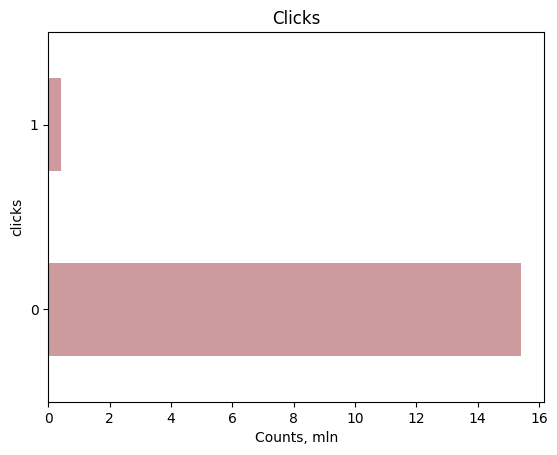

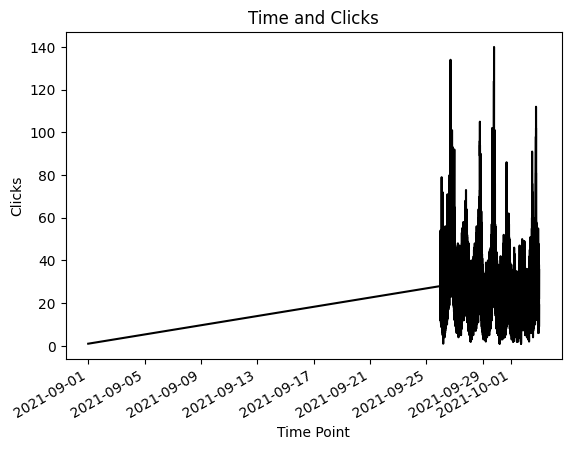

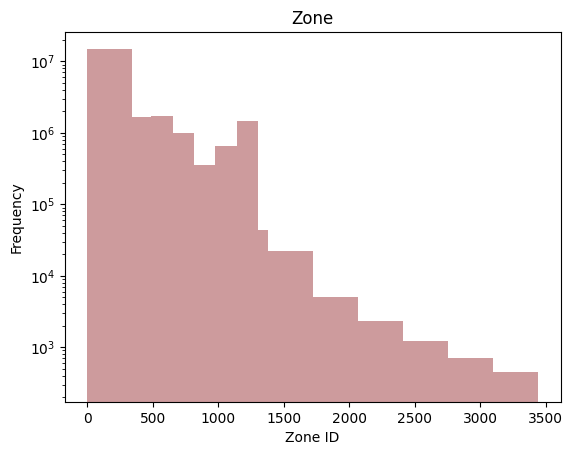

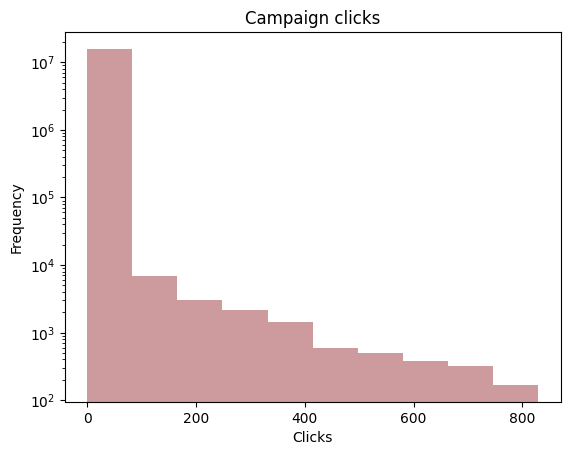

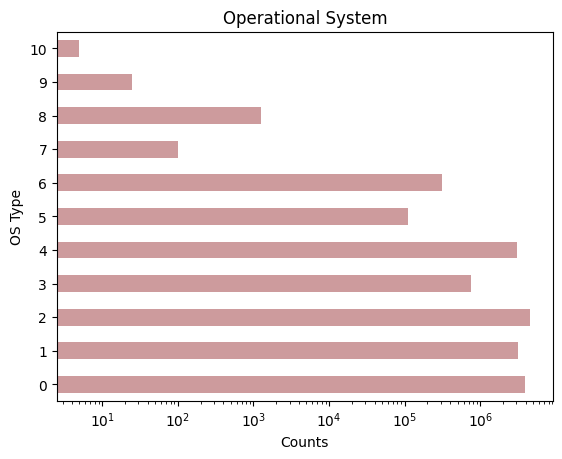

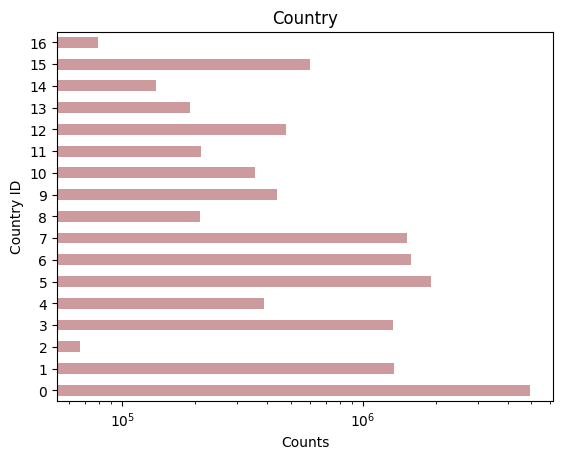

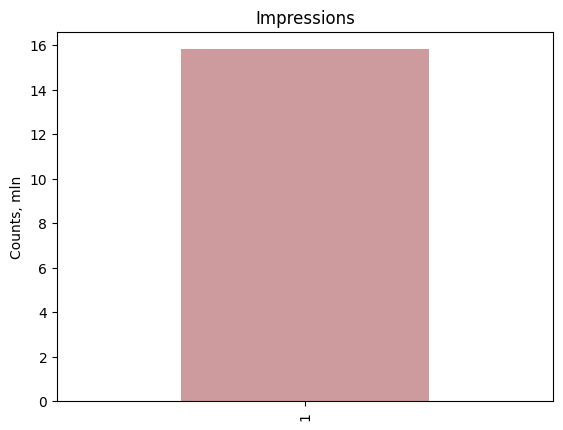

In [7]:
analysis(data)

Заметим несколько особенностей в данных:

1. Данные несбалансированы: кликов достаточно мало.

2. Почти все данные имеют место в последней неделе сентября и одно наблюдение за 1 сентября: удалять это наблюдение не будем.

3. Данные по расположение рекламы (*zone_id*) также несбалансированы: при построении фичей перегруппируем их.

4. Распределение кликов до показа рекламы: будем использовать фичу как бинарную - был клик до показа или нет

5. Некоторые ОС встречаются очень редко: отнесем их в одну категорию.

6. В *impressions* только одно значение: эту переменную использовать не будем.

7. *banner_id* имеет смысл использовать, если мы хотим предсказывать клик для уже имеющихся баннеров, но если появятся новые, такая фича будет неактуальна - использовать не будем.

## Feature engineering

In [8]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:

    # в impressions все единицы - удалим колонку
    data = data.drop('impressions', axis = 1)

    # date_time
    ## достанем из date_time время суток и день недели
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour

    ## посмотрим на распределение кликов в зависимости от времени суток и дня недели
    fig, axes = plt.subplots(1,2, figsize = (10, 4))
    ((data[data['clicks'] == 0]['day']).value_counts().sort_index() / 1e+6).plot.barh(title = 'No clicks through daytime', ylabel = 'Weekday Index', xlabel = 'Number of obs, mln', ax = axes[0])
    ((data[data['clicks'] == 1]['day']).value_counts().sort_index() / 1000).plot.barh(title = 'Clicks through daytime', ylabel = 'Weekday Index', xlabel = 'Number of clicks, ths', ax = axes[1])
    plt.show()


    fig, axes = plt.subplots(1,2, figsize = (10, 7))
    ((data[data['clicks'] == 0]['hour']).value_counts().sort_index() / 1e+6).plot.barh(title = 'No clicks through daytime', ylabel = 'Hour', xlabel = 'Number of obs, mln', ax = axes[0])
    ((data[data['clicks'] == 1]['hour']).value_counts().sort_index() / 1000).plot.barh(title = 'Clicks through daytime', ylabel = 'Hour', xlabel = 'Number of clicks, ths', ax = axes[1])
    plt.show()

    ## заметим, что для времени суток распределения по кликам/некликам практически не отличаются (воспользуемся этой фичей как пересечением с днем недели)
    data['day_hour_interact'] = data['day'].astype(str) + data['hour'].astype(str)
    data['day_hour_interact'] = pd.factorize(data['day_hour_interact'])[0]

    # zone_id
    counts = data['zone_id'].value_counts()
    idxs = counts[counts < 20].index
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1

    # os_id
    data.loc[data['os_id'] > 7, 'os_id'] = 7

    # campaign clicks
    # data['log_clicks'] = data['campaign_clicks'].log()
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')

    # сделаем one-hot encoding для всех категориальных фичей
    ## разделим на обучающую и тестовую выборку: тестовая - последний день датасета
    x_train = data[data['date_time'] < pd.to_datetime('2021-10-02')]
    y_train = x_train['clicks']
    x_test = data[~(data['date_time'] < pd.to_datetime('2021-10-02'))]
    y_test = x_test['clicks']
    ## удалим все фичи, которые не надо делать dummies
    x_train = x_train.drop(columns = ['campaign_clicks', 'date_time', 'clicks', 'banner_id'])
    x_test = x_test.drop(columns = ['campaign_clicks', 'date_time', 'clicks', 'banner_id'])


    # encoder для one-hot encoding
    encoder = OneHotEncoder(sparse=True, drop = 'first', handle_unknown='ignore')
    X_train = encoder.fit_transform(x_train.astype(np.int16))
    X_test = encoder.transform(x_test.astype(np.int16))


    return X_train, y_train, X_test, y_test

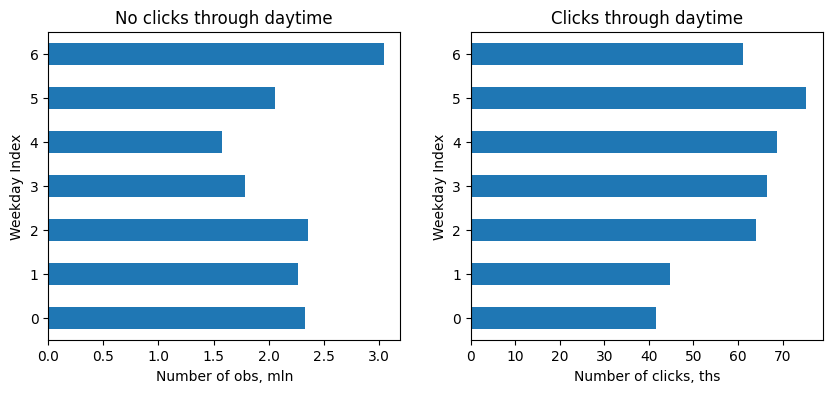

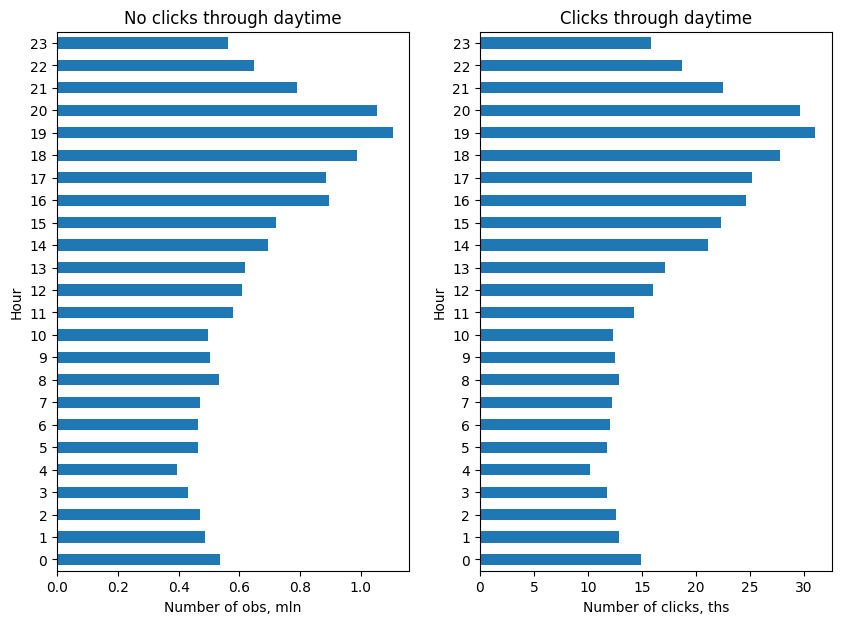

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [9]:
X_train, y_train, X_test, y_test = feature_engineering(data)

## Линейная модель: логистическая регрессия
+ Будем использовать метод оптимизации Ньютона-Холецкого (хорошо работает, когда количество наблюдений больше количества фичей и с one-hot энкодами)

In [10]:
def create_model(X_train, y_train, C = 1):
    lr = LogisticRegression(C = C, solver = 'newton-cholesky', max_iter = 100000, class_weight = 'balanced')
    lr.fit(X_train, y_train)
    return lr

In [11]:
def evaluate_model(model, X_test, y_test):
    # making predictions
    y_pred = model.predict_proba(X_test)
    
    # baseline
    baseline = np.zeros(len(y_test))
    baseline_ = np.zeros((len(y_test), 2))
    baseline_[:, 0] = 1.0
    
    # baseline results
    print('Baseline metrics: ')
    print('roc_auc: ', roc_auc_score(y_test, baseline_[:, 1]))
    print('log loss: ', log_loss(y_test, baseline_))
    print('f1-score: ', f1_score(y_test, baseline))
    print('accuracy: ', accuracy_score(y_test, baseline))
    
    # my model assessment
    print('My model metrics:')
    print('roc auc score: ', roc_auc_score(y_test, y_pred[:, 1]))
    print('log loss score: ', log_loss(y_test, y_pred))
    print('f1-score: ', f1_score(y_test, np.argmax(y_pred, axis = 1)))
    print('accuracy score: ', accuracy_score(y_test, np.argmax(y_pred, axis = 1)))

### Оценка и сравнение с бейзлайном
> бейзлайн: всегда предсказывать неклик

In [12]:
# Trying the default regularization parameter
model = create_model(X_train, y_train)
evaluate_model(model, X_test, y_test)

Baseline metrics: 
roc_auc:  0.5
log loss:  1.2758806369585063
f1-score:  0.0
accuracy:  0.9646017948518021
My model metrics:
roc auc score:  0.7386844380675525
log loss score:  0.5900420133310496
f1-score:  0.13332260327886994
accuracy score:  0.6762549918317615


In [20]:
def cv(X_train, y_train):
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    lr = LogisticRegression(solver = 'newton-cholesky', max_iter = 100000, class_weight = 'balanced', verbose = 1)
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='roc_auc', verbose = 3)
    grid_search.fit(X_train, y_train)
    print('best C: ', grid_search.best_params_['C'])
    print('roc auc score: ', grid_search.best_score_)
    return grid_search

In [21]:
model = cv(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Newton iter=1
  Check Convergence
    1. max |gradient| 0.005086219411283691 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.001888222745888024 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.0002752691692543329 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 1.552234975555796e-05 <= 0.0001
    2. Newton decrement 2.3971897218158406e-05 <= 0.0001
  Solver did converge at loss = 0.5758097052470988.
[CV 1/5] END ...........................C=0.001;, score=0.314 total time= 1.3min
Newton iter=1
  Check Convergence
    1. max |gradient| 0.002991006901716955 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.00022858935361241825 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 1.4518303982238807e-05 <= 0.0001
    2. Newton decrement 2.780703532467835e-05 <= 0.0001
  Solver did converge at loss = 0.6007857892769513.
[CV 2/5] END ..............

In [24]:
evaluate_model(model, X_test, y_test)

Baseline metrics: 
roc_auc:  0.5
log loss:  1.2758806369585063
f1-score:  0.0
accuracy:  0.9646017948518021
My model metrics:
roc auc score:  0.738596618493759
log loss score:  0.5896581285999282
f1-score:  0.13319971417556103
accuracy score:  0.6757942073614664


**Вывод:** метрики несильно зависят от коэффициента регуляризации C, используем любой. Например, *C* = 1.

In [25]:
# Финальный результат
model = create_model(X_train, y_train, C = 1)
evaluate_model(model, X_test, y_test)

Baseline metrics: 
roc_auc:  0.5
log loss:  1.2758806369585063
f1-score:  0.0
accuracy:  0.9646017948518021
My model metrics:
roc auc score:  0.7386844380675525
log loss score:  0.5900420133310496
f1-score:  0.13332260327886994
accuracy score:  0.6762549918317615
